# TIME SERIES ANALYSIS

In this notebook I will be working with time series. Workflow will include data analysis and cleaning, checking whether times series is stationary or not, reworking values for series to become stationary
and eventually forecasting.

В этом ноутбуке я буду работать с анализом временном ряда. Работа будут включать анализ данных и очистку, проверку стационарный ли временной ряд. Приведу данные в временном ряду к стационарности, чтобы в итоге попытаться дать 
дальнейший прогноз.

Import modules

Импорт модулей

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
import numpy as np
import matplotlib as mpl
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import acf, pacf

sns.set_style("whitegrid")
plt.style.use("bmh") #bmh ggplot
mpl.rcParams['figure.figsize'] = 15,6
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [5]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

Import dataset

Импорт датасет

In [7]:
df = pd.read_csv('AirPassengers.csv')

In [8]:
print(df.head())

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


'Month' column contains dates formatted as 'year-month'. 
'#Passengers' column contains the number of passengers for each month.

Колонка 'Month' содержит даты в формате 'год-месяц'.
'#Passengers' содержит количество пассажиров в месяц.

Using pandas to_datetime() method let's convert 'Month' column into 'year-month-day' format. Let's also convert this column into index.

При помощи метода to_datetime() модуля pandas, переформатируем колонку 'Month' в формат 'год-месяц-день'. Также назначим эту колонку индексом таблицы.

In [10]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
print(df.head())

       Month  #Passengers
0 1949-01-01          112
1 1949-02-01          118
2 1949-03-01          132
3 1949-04-01          129
4 1949-05-01          121


In [11]:
df.index = df['Month']

del df['Month']

print(df.head())

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


Let's visualize our data next.

Нарисуем наш график.

Text(0, 0.5, 'Number of Passengers')

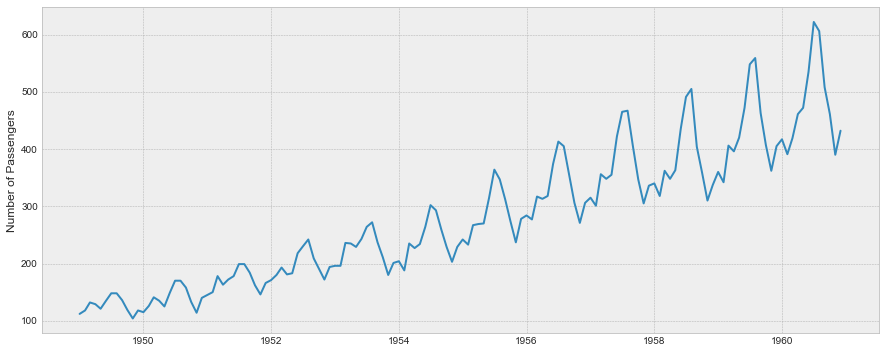

In [12]:
ts = df['#Passengers']

plt.plot(ts)
plt.ylabel('Number of Passengers')

Now that we have our data plotted and we can proceed onto reworking it for forecasting, let's formulate what stationary time series is.
Time series is called stationary, when this time series properties do not depend on time at which the series is observed. 
Specifically, time series is stationary, when over time its mean and variance do not change.

Time series has four components. Any time sesries can contain some or all of the following:

**Trend component** - long term pattern of time series. It can be positive or negative. If time series does not show change in pattern
then series is stationary in the mean.

**Cyclycal component** - any pattern showing an up and down change in time series around given trend.
Duration of cycle usually is specific to type of activity analyzed.

**Seasonal component** - pattern of regular fluctuations in time series during the same month (or months) every year.
For example, retail sales peak during the month of December.

**Irregular component** - unpredictable component. In forecasting, the objective is to “model” all the components to the point that the only component 
that remains unexplained is the random component.

Теперь, когда у нас есть данные, и мы можем приступить к их переработке для прогнозирования, давайте сформулируем, что такое стационарный временной ряд.
Временной ряд называется стационарным, когда свойства этого ряда не зависят от времени, в которое наблюдается ряд.
В частности, временной ряд является стационарным, если с течением времени его среднее значение и дисперсия не меняются.

Временной ряд состоит из четырех компонентов. Любые временные серии могут содержать некоторые или все из следующего:

**Тренд** - тенденция изменения показателей временного ряда. Он может быть положительным или отрицательным. Если временной ряд не показывает изменений в модели
тогда ряд стационарен в среднем значении.

**Цикл** - любой паттерн, показывающий изменение во временном ряду вверх и вниз вокруг заданного тренда.
Продолжительность цикла обычно зависит от типа анализируемой деятельности.

**Сезон** – закономерность регулярных колебаний временных рядов в течение одного и того же месяца (или месяцев) каждого года.
Например, рост розничных продаж в декабре.

**Нерегулярный компонент** - непредсказуемый компонент. При прогнозировании цель состоит в том, чтобы «смоделировать» все компоненты до такой степени, что единственный компонент
что остается необъяснимым, это нерегулярный компонент

Now I will rework time series to bring it to stationarity.
Goals:
It should have constant mean.
It should have constant variance or standard deviation.
Auto-covariance should not depend on time.

Теперь я переработаю временной ряд, чтобы привести его к стационарности.
Цели:
Постоянное среднее значение.
Постоянная дисперсия или стандартное отклонение.
Автоковариация не должна зависеть от времени. 

To assess stationarity of time series I will be using rolling statistics plot with Dickey-Fuller test results, so I am going to define a function
that takes time series as inport and generates plot and statistics as output.

Для оценки стационарности временных рядов я буду использовать график скользящей статистики с результатами Dickey-Fuller теста, поэтому я напишу функцию
который принимает временной ряд в качестве входных данных и генерирует график и статистику в качестве выходных данных. 

In [15]:
def test_stationarity(timeseries):
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    
    #plotting rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show()
    
    #Dickey_Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

Let's test it out on out time series.

Проверим функцию на нашем временном ряду.

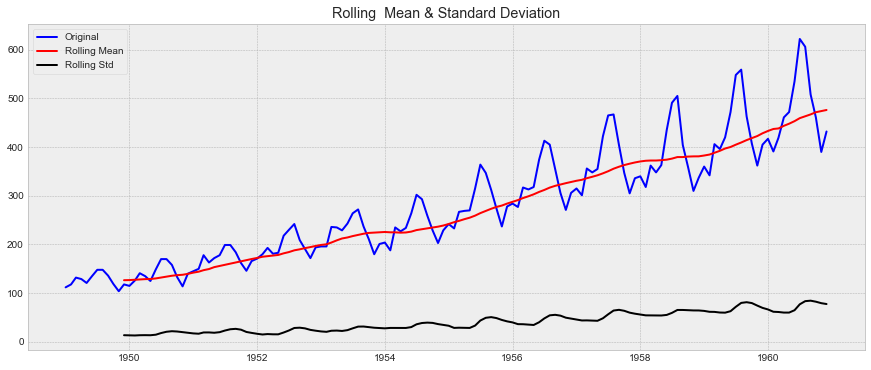

Results of Dickey-Fuller Test:
Test Statistic                  0.82
p-value                         0.99
#Lags Used                     13.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [16]:
test_stationarity(ts)

Mean is increasing continously. Hence, this time series can not be called stationary.
Also, if we compare test statistic is higher than critical values. For us to say that series is not stationary, 
test statistics needs to be negative (at least less than critical values, but the lower the better). Thus, based on these results we cannot say that series is stationary.

Среднее значение постоянно увеличивается. Следовательно, этот временной ряд нельзя назвать стационарным.
Кроме того, если сравнивнить тестовую статистику с критическими значениями, видно, что тестовая статистика выше.
Для того, чтобы быть уверенными, что ряд не является стационарным,
тестовая статистика должна быть отрицательной (как минимум меньше критических значений, но чем ниже, тем лучше). Таким образом, на основании этих результатов нельзя сказать, что ряд является стационарным. 

Also, the fact that our data is not stationary is visible from the fact that p-value is greater than 5 percent 
Same conclusion can be drown from just looking at the graph since there is an obvious positive trend in number of passengers, but 
it is great to have statistical support.

Кроме того, тот факт, что наши данные не являются стационарными, виден из того факта, что p-значение больше 5 процентов
Тот же вывод можно сделать, просто взглянув на график, так как очевидна положительная динамика количества пассажиров, но
здорово иметь статистическую поддержку. 

Now I will try to make series as stationary, as I can. Let's start with estimating and eliminating trend.

Сейчас постараюсь сделать серию максимально стационарной, насколько смогу. Начнем с оценки и устранения тренда. 

It is clear that there is a significant positive trend in studied time series.
I'm going to use log transformation to penalize higher values more than smaller values.

Видно, что в изучаемом временном ряду наблюдается значимая положительная тенденция.
Я использую логарифмическое преобразование, чтобы штрафовать высокие значения в большей степени, чем маленькие. 

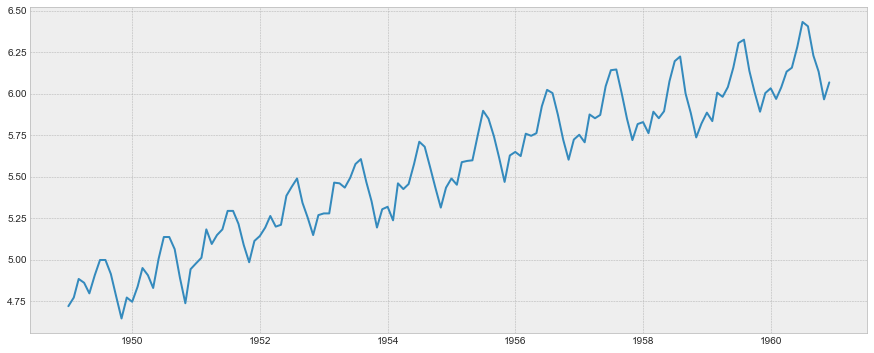

In [21]:
ts_log = np.log(ts)
plt.plot(ts_log)

Now to estimate and remove this trend I will use smoothing method - taking rolling averages.

Теперь, чтобы оценить и убрать этот тренд, я воспользуюсь методом сглаживания - с применением скользящих средних. 

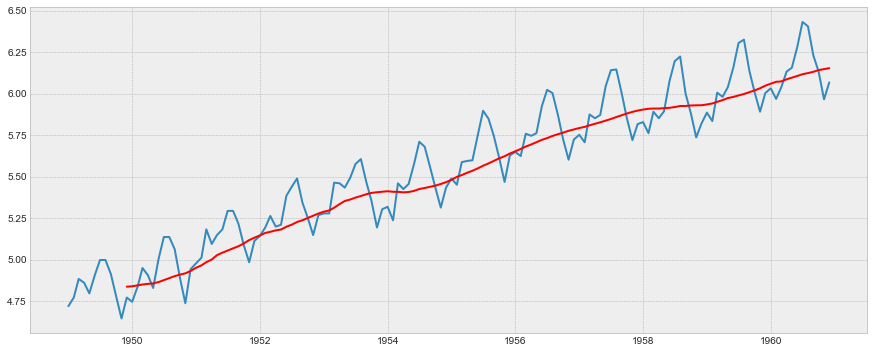

In [23]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color = 'red')

Take moving average out

Убираем скользящее среднее 

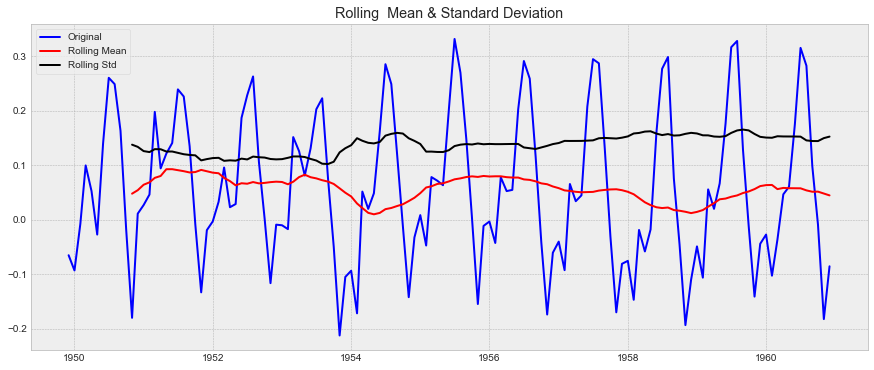

Results of Dickey-Fuller Test:
Test Statistic                 -3.16
p-value                         0.02
#Lags Used                     13.00
Number of Observations Used   119.00
Critical Value (1%)            -3.49
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58
dtype: float64


In [24]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(ts_log_moving_avg_diff)

The rolling values appear to be varying slightly but there is no specific trend. 
Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series. 

Значения скользящих значений немного различаются, но определенной тенденции нет.
Кроме того, тестовая статистика меньше 5% критических значений, поэтому мы можем с уверенностью 95% сказать, что это стационарный ряд. 

However, a drawback in this particular approach is that the time-period has to be strictly defined. 
In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. 
So for problems like that we can take a ‘weighted moving average’ where more recent values are given a higher weight. 
A popular method is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.

Однако недостатком этого конкретного подхода является то, что период времени должен быть строго определен.
В этом случае мы можем взять среднегодовые значения, но в сложных ситуациях, таких как прогнозирование цены акций, трудно выбрать определенное число.
Для подобных задач мы можем использовать «взвешенное скользящее среднее», где более поздним значениям присваивается более высокий вес.
Популярным методом является экспоненциально взвешенное скользящее среднее, при котором веса присваиваются всем предыдущим значениям с коэффициентом затухания. 

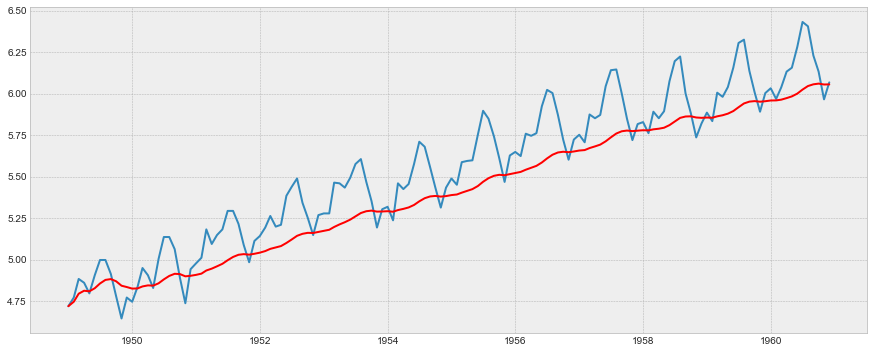

In [29]:
exp_weighted_avg = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log)
plt.plot(exp_weighted_avg, color = 'red')

ts_log_ema_diff = ts_log - exp_weighted_avg
test_stationarity(ts_log_ema_diff)

This approach test resilts have even lesser variations in mean and standard deviation in magnitude. 
Also, the test statistic is smaller than the 1% critical value, which is better than the previous case.

Этот подход показывает еще меньше вариации среднего значения и стандартного отклонения.
Кроме того, тестовая статистика меньше критического значения 1%, что лучше, чем в предыдущем случае. 

In [32]:
Now we need to eliminate seasonality. 
There are two methods we could use:

**Differencing** (taking the differece with a particular time lag)
**Decomposition** (modeling both trend and seasonality and removing them from the model)

Теперь нам нужно исключить сезонность.
Есть два метода, которые мы могли бы использовать:

**Дифференциация** (взятие разницы с определенной временной задержкой)
**Декомпозиция** (моделирование как тренда, так и сезонности и удаление их из модели)

## Differencing

<AxesSubplot:xlabel='Month'>

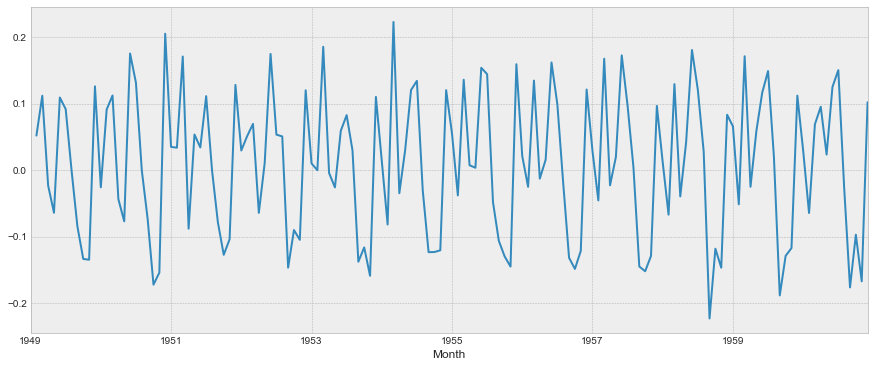

In [34]:
ts_log_diff = ts_log - ts_log.shift()
ts_log.diff().plot()

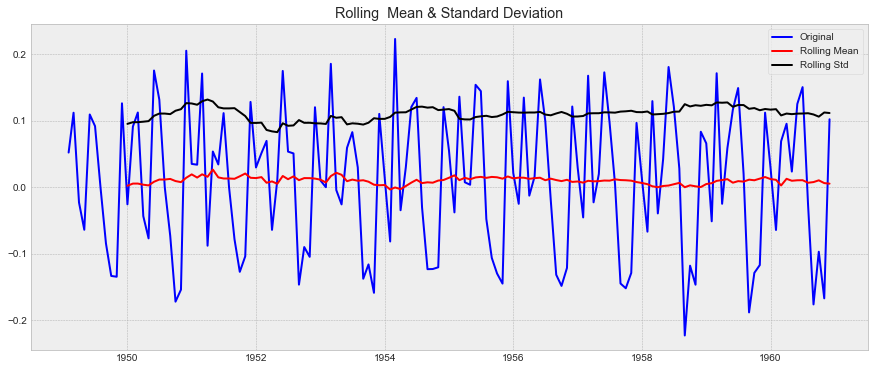

Results of Dickey-Fuller Test:
Test Statistic                 -2.72
p-value                         0.07
#Lags Used                     14.00
Number of Observations Used   128.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [35]:
ts_log_diff.dropna(inplace = True)
test_stationarity(ts_log_diff)

With this approach the mean and std variations have small variations with time. 
Also, the Dickey-Fuller test statistic is less than the 10% critical value, 
thus the time series is stationary only with 90% confidence. 

Let's try decomposition to see if we can yield better results.

При таком подходе средние и стандартные отклонения имеют небольшие изменения во времени.
Кроме того, статистика теста Дики-Фуллера меньше критического значения 10%,
Таким образом, временной ряд является стационарным только с достоверностью 90%.

Давайте попробуем декомпозицию, чтобы увидеть, сможем ли мы получить лучшие результаты. 

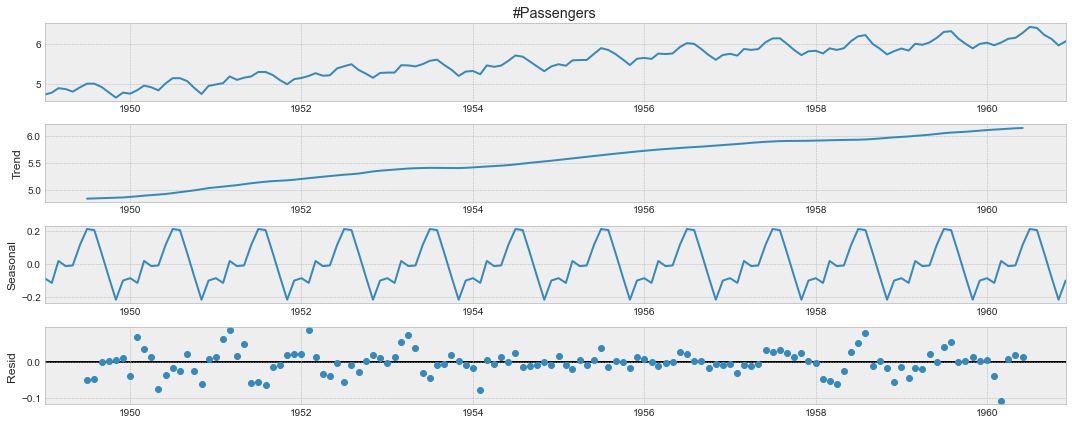

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()

On the graph we can see that seasonal is stationary, while residuals not so obviously. Let's check residuals.

На графике видно, что сезонность стационарна, а residuals не столь очевидно стационарны. Проверим residuals. 

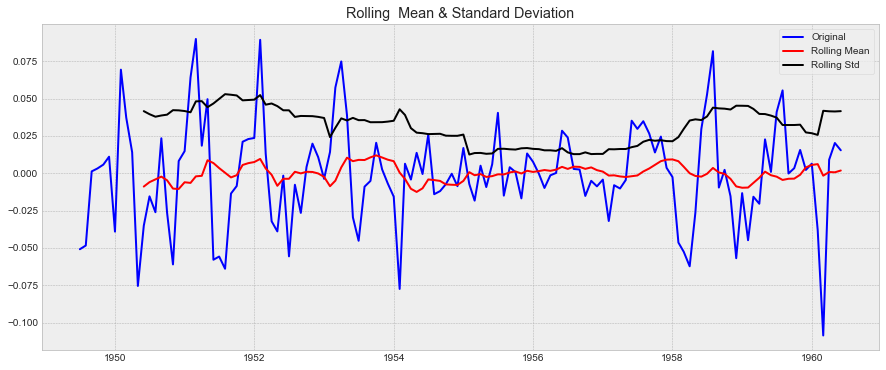

Results of Dickey-Fuller Test:
Test Statistic                 -6.33
p-value                         0.00
#Lags Used                      9.00
Number of Observations Used   122.00
Critical Value (1%)            -3.49
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58
dtype: float64


In [41]:
residual.dropna(inplace = True)
test_stationarity(residual)

Now we can get onto forecasting our time series. I'm going to use time series after differencing.

Having performed the trend and seasonality estimation techniques, there can be two situations: 
1. A strictly stationary series with no dependence among the values. But this is very rare. 
2. A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

Теперь мы можем перейти к прогнозированию нашего временного ряда. Я собираюсь использовать временные ряды после дифференциации.

После применения методов оценки тренда и сезонности могут возникнуть две ситуации:
1. Строго стационарный ряд без зависимости между значениями. Но это случается очень редко.
2. Ряд со значительной зависимостью между значениями. В этом случае нам нужно использовать статистические модели, такие как ARIMA, для прогнозирования данных. 

The ARIMA forecasting for a stationary time series is a linear equation. The predictions depend on the parameters (p,d,q) of the ARIMA model:

1. Number of AR (Auto-Regressive) terms (p): AR terms are lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

3. Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

Модель ARIMA для стационарного временного ряда представляет собой линейное уравнение. Прогнозы зависят от параметров (p, d, q) модели ARIMA:

1. Количество членов AR (авторегрессивных) (p): Условия AR представляют собой лаги зависимой переменной. Например, если p равно 5, предикторами для x(t) будут x(t-1)….x(t-5).

2. Количество членов MA (скользящего среднего) (q): члены MA представляют собой запаздывающие ошибки прогноза в уравнении прогнозирования. Например, если q равно 5, предикторами для x(t) будут e(t-1)….e(t-5), где e(i) — разница между скользящим средним в i-й момент и фактическим значением.

3. Количество различий (d): Это количество несезонных различий, т.е. в данном случае мы взяли различие первого порядка. Так что либо мы можем передать эту переменную и присвоить d=0, либо передать исходную переменную и присвоить d=1. Оба будут генерировать одинаковые результаты. 

An importance concern here is how to determine the value of ‘p’ and ‘q’. I will use two plots to determine these numbers.

1. Autocorrelation Function (ACF): It is a measure of the correlation between the time series with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

2. Partial Autocorrelation Function (PACF): This measures the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

Важным вопросом здесь является то, как определить значение «p» и «q». Я буду использовать два графика для определения этих чисел.

1. Автокорреляционная функция (ACF): это мера корреляции между временной ряд с запаздывающей версией самого себя. Например, при задержке 5 АКФ будет сравнивать ряды в момент времени «t1»… «t2» с сериями в моменты времени «t1-5»…»t2-5» (t1-5 и t2 являются конечными точками).

2. Функция частичной автокорреляции (PACF): измеряет корреляцию между временными рядами с запаздывающей версией самого себя, но после исключения вариаций, уже объясненных промежуточными сравнениями. Например, при лаге 5 он проверит корреляцию но удалите эффекты, уже объясненные лагами с 1 по 4. 

ACF and PACF plots

In [45]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

E:\anaconda2\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Plot ACF and PACF:

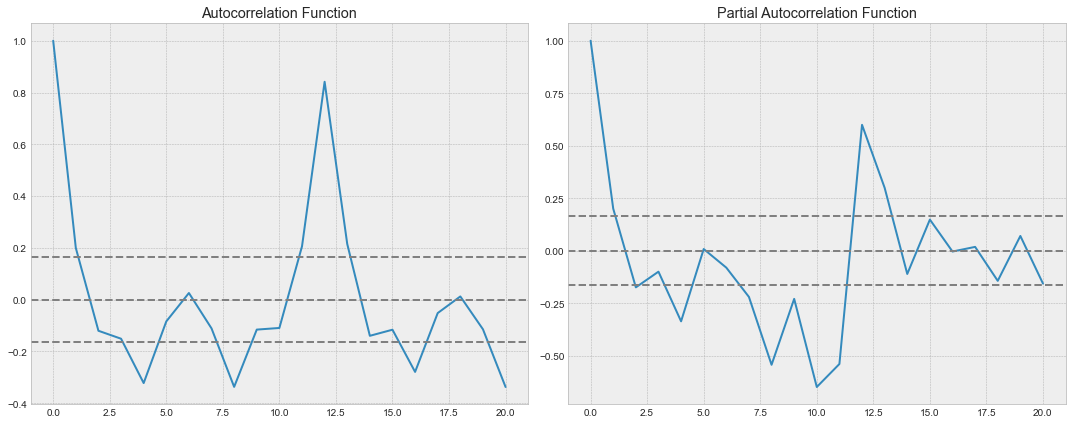

In [46]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray') #Add a horizontal line across the axis at y = 0.
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout() #Automatically adjust subplot parameters to give specified padding.

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. 
These can be used to determine the ‘p’ and ‘q’ values as:

⋅⋅* p – The lag value where the PACF chart crosses the upper confidence interval for the first time (p=2).
⋅⋅* q – The lag value where the ACF chart crosses the upper confidence interval for the first time(q=2).

На этом графике две пунктирные линии по обе стороны от 0 — это доверительные интервалы.
Их можно использовать для определения значений «p» и «q» следующим образом:

⋅⋅* p – значение запаздывания, при котором график PACF впервые пересекает верхний доверительный интервал (p=2).
⋅⋅* q – значение запаздывания, при котором график ACF впервые пересекает верхний доверительный интервал (q=2). 

Now, lets make 3 different ARIMA models considering individual as well as combined effects. 
We will also print the RSS for each. Please note that here RSS is for the values of residuals and not actual series.

Теперь давайте создадим 3 разные модели ARIMA: сначала по отдельности с параметрами p и q, а потом совместную.
Мы также распечатаем RSS для каждого. Обратите внимание, что здесь RSS для значений residuals, а не фактического временного ряда. 

## AR Model

E:\anaconda2\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
E:\anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.w

Text(0.5, 1.0, 'RSS: 1.5023')

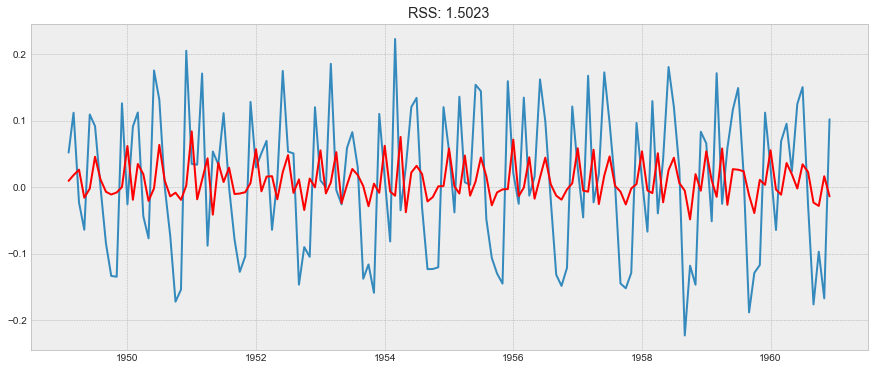

In [47]:
model = ARIMA(ts_log, order = (2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - ts_log_diff)**2)) #Residual sum of squares

## MA Model

E:\anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
E:\anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'RSS: 1.4721')

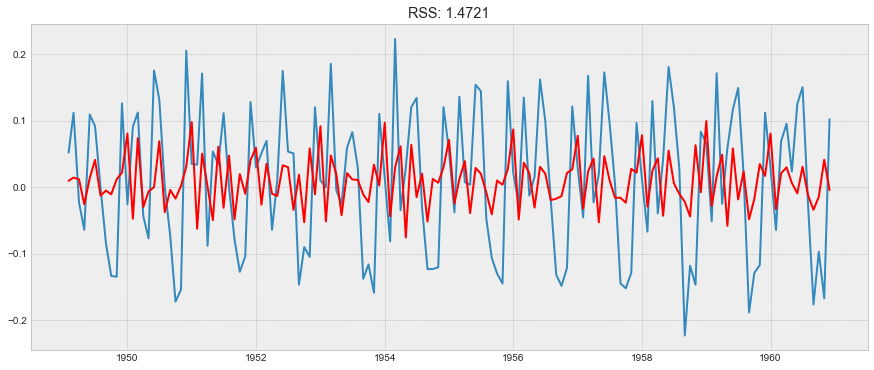

In [48]:
model = ARIMA(ts_log, order= (0, 1, 2))  
results_MA = model.fit(disp = -1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color= 'red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues - ts_log_diff)**2))

## Combined Model

E:\anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
E:\anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
E:\anaconda2\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore

Text(0.5, 1.0, 'RSS: 1.0292')

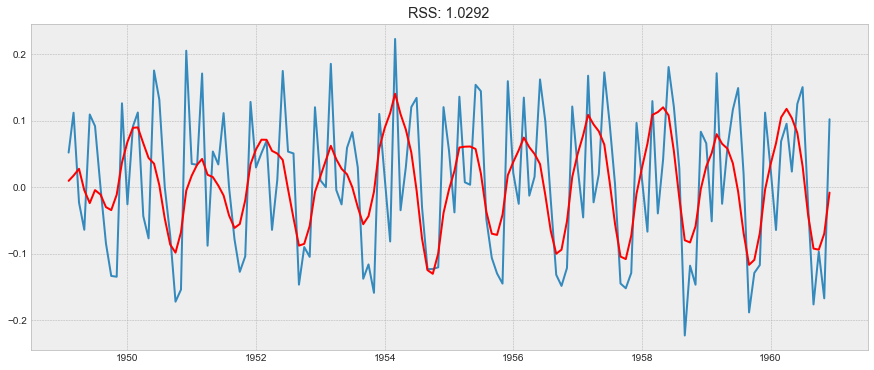

In [49]:
model = ARIMA(ts_log, order = (2, 1, 2))  
results_ARIMA = model.fit(disp = -1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color= 'red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - ts_log_diff)**2))

Here we can see that the AR and MA models have almost the same RSS but combined is significantly better.

Здесь мы видим, что модели AR и MA имеют почти одинаковый RSS, но в сочетании значительно лучше. 

Back to original scale

Возвращаемся к оригинальному датасету

In [51]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.01
1949-03-01    0.02
1949-04-01    0.03
1949-05-01   -0.00
1949-06-01   -0.02
dtype: float64

In [52]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01   0.01
1949-03-01   0.03
1949-04-01   0.05
1949-05-01   0.05
1949-06-01   0.03
dtype: float64

In [53]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01   4.72
1949-02-01   4.73
1949-03-01   4.75
1949-04-01   4.77
1949-05-01   4.77
dtype: float64

Text(0.5, 1.0, 'RMSE: 90.1043')

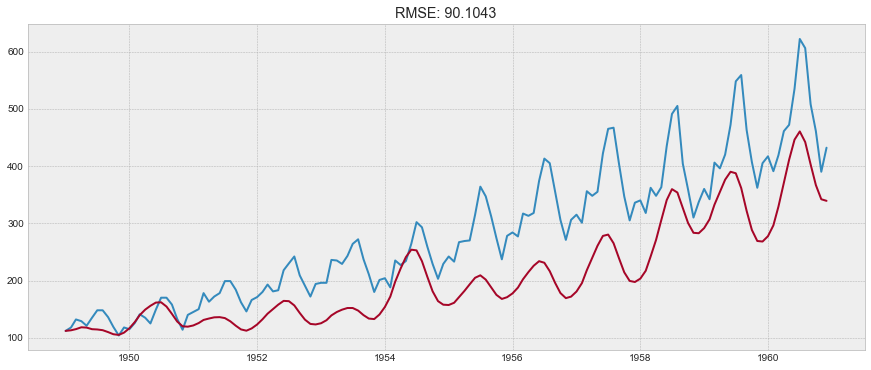

In [54]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

This predicton is not that much good as it should be and root mean square error is also very high.

Прогноз вышел не очень хорошим. RMSE также высокий.

## Another method (SARIMAX)

## Попробуем другой метод - SARIMAX

## Parameter Selection for the ARIMA Time Series Model

## Выбор параметров для модели ARIMA

In [60]:
import itertools
p = d = q = range(2)
pdq = list(itertools.product(p, d, q))      # Generate all different combinations of p, d and q triplets /// # Создаем комбинации p,d,q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]       # Generate all different combinations of seasonal p, d and q. /// # Создаем сезонные комбинации p,d,q

use SARIMAX to get the best parameters

применяем SARIMAX для подбора лучших параметров для нашей модели

In [62]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")           
AIC_df = pd.DataFrame({}, columns = ['param', 'param_seasonal', 'AIC'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_log, order = param, seasonal_order = param_seasonal, enforce_stationarity = False, enforce_invertibility = False)
            results = mod.fit()
            print('ARIMA{}x{}-AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[param, param_seasonal, results.aic]], columns = ['param', 'param_seasonal', 'AIC'])
            AIC_df = AIC_df.append(temp, ignore_index = True)
            del temp
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)-AIC:898.7367486840988
ARIMA(0, 0, 0)x(0, 0, 1, 12)-AIC:687.3749017314519
ARIMA(0, 0, 0)x(0, 1, 0, 12)-AIC:-150.6257730094589
ARIMA(0, 0, 0)x(0, 1, 1, 12)-AIC:-179.24122961708045
ARIMA(0, 0, 0)x(1, 0, 0, 12)-AIC:-344.53629719317615
ARIMA(0, 0, 0)x(1, 0, 1, 12)-AIC:-342.60891903671467
ARIMA(0, 0, 0)x(1, 1, 0, 12)-AIC:-225.9086915292443
ARIMA(0, 0, 0)x(1, 1, 1, 12)-AIC:-301.460456490905
ARIMA(0, 0, 1)x(0, 0, 0, 12)-AIC:704.009739506531
ARIMA(0, 0, 1)x(0, 0, 1, 12)-AIC:509.22247300887295
ARIMA(0, 0, 1)x(0, 1, 0, 12)-AIC:-254.34077330176774
ARIMA(0, 0, 1)x(0, 1, 1, 12)-AIC:-248.4223167999257
ARIMA(0, 0, 1)x(1, 0, 0, 12)-AIC:-396.279446557322
ARIMA(0, 0, 1)x(1, 0, 1, 12)-AIC:-395.7137290684859
ARIMA(0, 0, 1)x(1, 1, 0, 12)-AIC:-271.4312342408366
ARIMA(0, 0, 1)x(1, 1, 1, 12)-AIC:-339.4992870120079
ARIMA(0, 1, 0)x(0, 0, 0, 12)-AIC:-230.0413295835742
ARIMA(0, 1, 0)x(0, 0, 1, 12)-AIC:-296.9570921223848
ARIMA(0, 1, 0)x(0, 1, 0, 12)-AIC:-431.2309107055035
ARIMA(0, 1, 0)

In [64]:
min_aic = AIC_df.sort_values(by = 'AIC').iloc[0]    # Row with minimum AIC value /// # Минимальный AIC ряд
print(min_aic)
model = sm.tsa.statespace.SARIMAX(ts_log, order = min_aic.param, seasonal_order = min_aic.param_seasonal, enforce_stationarity = False, enforce_invertibility = False)
results = model.fit()
print(results.summary().tables[1])

param                 (1, 0, 1)
param_seasonal    (1, 0, 1, 12)
AIC                     -477.62
Name: 45, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9419      0.039     24.101      0.000       0.865       1.018
ma.L1         -0.3803      0.093     -4.092      0.000      -0.562      -0.198
ar.S.L12       1.0200      0.003    302.518      0.000       1.013       1.027
ma.S.L12      -0.5747      0.107     -5.387      0.000      -0.784      -0.366
sigma2         0.0013      0.000      9.240      0.000       0.001       0.002


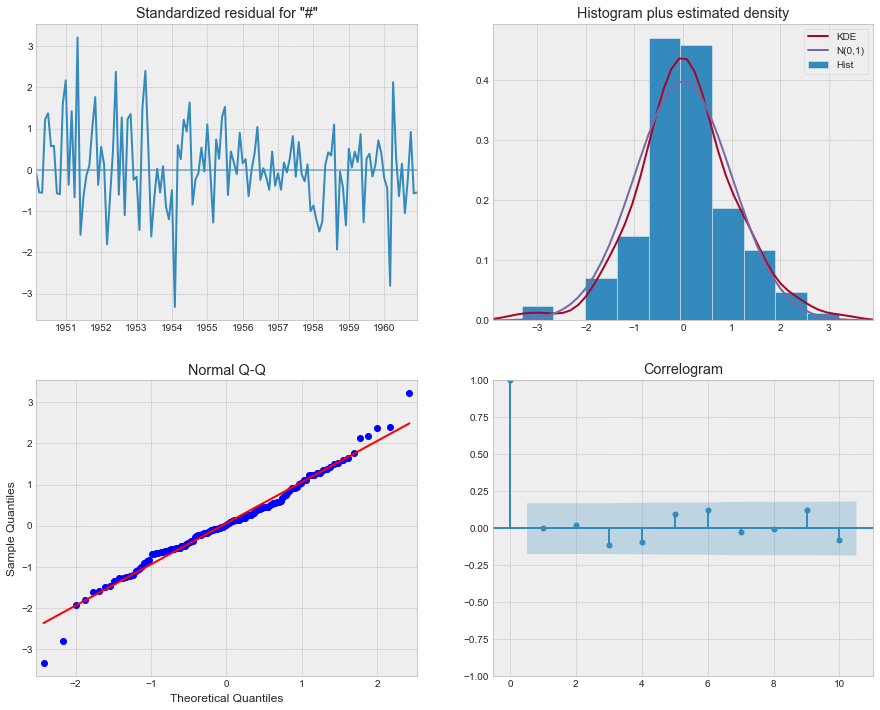

In [65]:
results.plot_diagnostics(figsize=(15, 12))    #Generate model diagnostics and investigate for any unusual behavior.
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated 
and normally distributed with zero-mean. In this case, our model diagnostics suggests 
that the model residuals are normally distributed based on the following:

1. In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed. 

2. The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed. 

3. The residuals over time (top left plot) don't display any obvious seasonality. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

Нашей основной задачей является обеспечение того, чтобы остатки нашей модели не коррелировали
и нормально распределены с нулевым средним. В этом случае наша модельная диагностика предлагает
что остатки модели нормально распределяются на основе следующего:

1. На верхнем правом графике мы видим, что красная линия KDE тесно связана с N(0,1) линия (где N(0,1) стандартное обозначение нормального распределения со средним значением 0 и стандартное отклонение 1). Это хороший показатель того, что остатки нормально распределены.

2. График qq внизу слева показывает, что упорядоченное распределение. Количество остатков (синие точки) соответствует линейному тренду взятых проб из стандартного нормального распределения с N(0, 1). Опять же, это сильный показатель что остатки нормально распределены.

3. Остатки во времени (верхний левый график) не имеют явной сезонности. Это подтверждается автокорреляцией (т.е. коррелограммой) график в правом нижнем углу, который показывает, что остатки временных рядов имеют низкую корреляцию с запаздывающими версиями самого себя.

Эти наблюдения приводят нас к выводу, что наша модель обеспечивает удовлетворительное соответствие, которое может помочь нам понять наши данные временного ряда и прогнозировать будущие значения. 

Obtain values for forecasts of the time series from 1958

Получаем значения для прогнозов временного ряда с 1958 г. 

In [67]:
pred = results.get_prediction(start = pd.to_datetime('1958-01-01'), dynamic = False)

pred_ci = pred.conf_int()
pred_ci.head()

,lower #Passengers,upper #Passengers
1958-01-01,5.79,5.93
1958-02-01,5.73,5.88
1958-03-01,5.87,6.02
1958-04-01,5.83,5.97
1958-05-01,5.82,5.96


**Note:** The dynamic = False argument ensures that we produce one-step ahead forecasts, 
meaning that forecasts at each point are generated using the full history up to that point.

**Примечание:** Аргумент dynamic = False гарантирует, что мы будем производить прогнозы на один шаг вперед,
означает, что прогнозы в каждой точке генерируются с использованием полной истории до этой точки. 

Plot the forecasted values with historical data

График прогнозируемых значений с историческими данными 

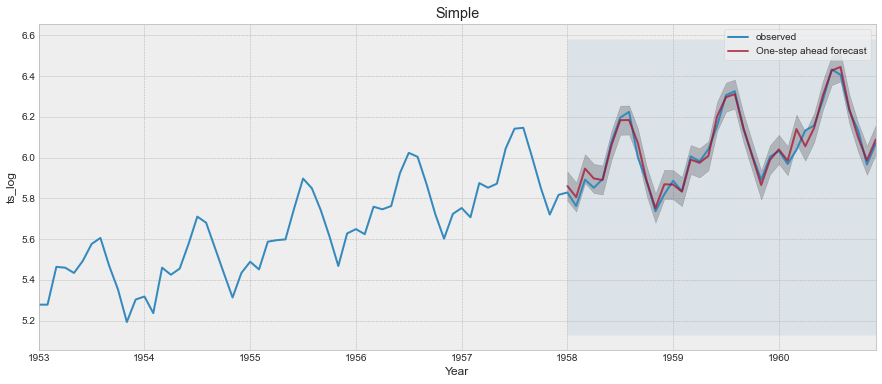

In [69]:
ax = ts_log['1953':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'One-step ahead forecast', alpha = 0.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = .2)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-01-01'), ts_log.index[-1], alpha = .1, zorder = -1)
plt.xlabel('Year')
plt.ylabel('ts_log')
plt.title('Simple')
plt.legend()

In [71]:
ts_log_forecasted = pred.predicted_mean     # From 1958 to 1960 (validation process)
ts_log_original = ts_log['1958-01-01':]
mse = ((ts_log_forecasted - ts_log_original) ** 2).mean()  # Mean square error
print('Mean Squared Error of forecast : {}'.format(round(mse,3)))

Mean Squared Error of forecast : 0.001


Mean square error is almost zero. This means our prediction is very accurate.

Среднеквадратическая ошибка почти равна нулю. Это означает, что наш прогноз очень точен. 